In [13]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import concurrent.futures
import networkx as nx
import seaborn as sns

In [14]:
class Agent:
    def __init__(self, memory_size, explorationRounds, minority_threshold):
        self.explorationRounds = explorationRounds
        self.memory_size = memory_size
        self.strategy_types = ['random', 'weighted_random', 'genetic', 'bayesian', 'adaptive', 'market_based', 'pattern_recognition','repeat_last','inverse_last']
        self.current_strategy = np.random.choice(self.strategy_types)
        self.strategy_scores = {strategy: 0 for strategy in self.strategy_types}
        self.pattern_memory = []
        self.bayesian_params = [[1, 1] for _ in range(2 ** memory_size)]
        self.adaptive_memory = []
        self.model_trained = False
        self.history_index_cache = {}
        self.decisionHistory = []
        self.learning_rate = 0.1  
        self.decision_prices = [1, 1]
        self.genetic_strategies = np.random.randint(2, size=(10, 2 ** memory_size))
        self.genetic_performance = np.zeros(10)  
        self.temperature = 1 
        self.last_strategy_change = 0  
        self.strategy_failure_count = {strategy: 0 for strategy in self.strategy_types}
        self.strategy_rewards = {strategy: 0 for strategy in self.strategy_types}
        self.particle_position = np.random.rand(2 ** memory_size) 
        self.particle_velocity = np.random.rand(2 ** memory_size) 
        self.personal_best_position = self.particle_position.copy()
        self.minority_threshold = minority_threshold
        self.wonLastRound = None
        self.choices=[]


    def decide(self, history):
        self.select_strategy()
        self.decisionHistory.append(self.current_strategy)
        if self.current_strategy == 'random':
            choice = self._random_decide()
        elif self.current_strategy == 'weighted_random':
            choice = self._weighted_random_decide()
        elif self.current_strategy == 'genetic':
            choice = self._genetic_decide(history)
        elif self.current_strategy == 'bayesian':
            choice = self._bayesian_decide(history)
        elif self.current_strategy == 'adaptive':
            choice = self.adaptive_decide(history)
        elif self.current_strategy == 'market_based':
            choice = self._market_based_decide()
        elif self.current_strategy == 'pattern_recognition':
            choice = self._pattern_recognition_decide(history)
        elif self.current_strategy == 'repeat_last':
            choice = self._repeat_last_decide()
        elif self.current_strategy == 'inverse_last':
            choice = self._inverse_last_decide()
        else:
            raise ValueError(f'Invalid strategy: {self.current_strategy}')
        self.choices.append(choice)
        return choice

    def _weighted_random_decide(self):
        return int(np.random.rand() < self.minority_threshold)

    def _repeat_last_decide(self):
        if self.wonLastRound == None:
            return np.random.choice([0, 1])
        elif self.wonLastRound:
            return self.choices[-1]
        else:
            return 1 - self.choices[-1]


    def _inverse_last_decide(self):
        if self.wonLastRound == None:
            return np.random.choice([0, 1])
        elif self.wonLastRound:
            return 1 - self.choices[-1]
        else:
            return self.choices[-1]

    def _random_decide(self):
        return np.random.choice([0, 1])
        
    def _genetic_decide(self, history):
        history_index = self._get_history_index(history)
        best_strategy_index = np.argmax(self.strategy_scores['genetic'])
        return self.genetic_strategies[best_strategy_index][history_index]
    
    def _bayesian_decide(self, history):
        history_index = self._get_history_index(history)
        alpha, beta = self.bayesian_params[history_index]
        return 0 if np.random.rand() < alpha / (alpha + beta) else 1

    def _pattern_recognition_decide(self, history):
        history_str = ''.join(map(str, history))
        decision = np.random.choice([0, 1])
        pattern_found = False
        next_move = None
        for past_history in self.pattern_memory:
            if len(past_history) > len(history_str) and past_history.endswith(history_str):
                pattern_found = True
                next_move = past_history[-len(history_str)-1]
                break
        if pattern_found and next_move:
            decision = 0 if next_move == '1' else 1  
        if history_str not in self.pattern_memory:
            self.pattern_memory.append(history_str)
        return decision


    def _market_based_decide(self):
        decision = 0 if self.decision_prices[0] < self.decision_prices[1] else 1
        if self.decision_prices[0] == self.decision_prices[1]:
            decision = np.random.choice([0, 1])
        return decision

    def adaptive_decide(self, history):
        if not self.adaptive_memory or np.random.rand() < self.learning_rate:
            return np.random.choice([0, 1])
        else:
            recent_decisions = self.adaptive_memory[-self.memory_size:]
            predicted_majority = int(np.mean(recent_decisions) >= self.minority_threshold)
            return 1 - predicted_majority

    def update_score(self, reward):
        if reward == 0:
            self.strategy_scores[self.current_strategy] -= 1
            self.strategy_failure_count[self.current_strategy] += 1
            self.wonLastRound = False
        else:
            self.strategy_scores[self.current_strategy] += reward
            self.strategy_rewards[self.current_strategy] += 1  
            self.strategy_failure_count[self.current_strategy] = 0
            self.wonLastRound = True


    def select_strategy(self):
        if len(self.decisionHistory) < self.explorationRounds or self.strategy_failure_count[self.current_strategy] > 3:
            self.current_strategy = np.random.choice(self.strategy_types)
            self.last_strategy_change = len(self.decisionHistory)
        else:
            self.current_strategy = self.softmax_selection()


    def softmax_selection(self):
        scores = np.array([self.strategy_scores[strategy] for strategy in self.strategy_types])
        failure_adjustment = np.array([1 / (1 + self.strategy_failure_count[strategy]) for strategy in self.strategy_types])
        time_since_change = np.array([len(self.decisionHistory) - self.last_strategy_change if strategy == self.current_strategy else 0 for strategy in self.strategy_types])
        adjusted_scores = scores * failure_adjustment + time_since_change
        exp_scores = np.exp(adjusted_scores / self.temperature)
        probabilities = exp_scores / np.sum(exp_scores)
        selected_strategy = np.random.choice(self.strategy_types, p=probabilities)
        if selected_strategy != self.current_strategy:
            self.last_strategy_change = len(self.decisionHistory)
        return selected_strategy

    def update_genetic_strategies(self, history, decision, outcome):
        history_index = self._get_history_index(history)
        for i, strategy in enumerate(self.genetic_strategies):
            if strategy[history_index] == decision:
                self.genetic_performance[i] += 1 if decision == outcome else -1
        if len(self.decisionHistory) % 10 == 0:
            self.evolve_genetic_strategies()

    def evolve_genetic_strategies(self):
        sorted_indices = np.argsort(self.genetic_performance)[::-1]
        num_parents = len(self.genetic_strategies) // 2
        parents = self.genetic_strategies[sorted_indices[:num_parents]]
        offspring = []
        for _ in range(len(self.genetic_strategies) - num_parents):
            # Choose parent indices from a 1-dimensional array of available parent indices
            parent_indices = np.random.choice(np.arange(num_parents), 2, replace=False)
            parent1, parent2 = parents[parent_indices[0]], parents[parent_indices[1]]
            crossover_point = np.random.randint(1, parent1.shape[0])
            child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
            offspring.append(child)
        mutation_rate = 0.01
        for child in offspring:
            if np.random.rand() < mutation_rate:
                mutation_point = np.random.randint(len(child))
                child[mutation_point] = 1 - child[mutation_point]
        self.genetic_strategies[sorted_indices[num_parents:]] = np.array(offspring)
        self.genetic_performance[sorted_indices[num_parents:]] = 0


    def update_strategy_data(self, history, decision, outcome):
        index = self._get_history_index(history)
        for i in range(len(self.bayesian_params)):
            if decision == outcome:
                self.bayesian_params[i][0] += 1
            else:
                self.bayesian_params[i][1] += 1
        self.adaptive_memory.append(decision)
        if len(self.adaptive_memory) > self.memory_size:
            self.adaptive_memory.pop(0)
        self.decision_prices[decision] += 0.1
        self.decision_prices[1 - decision] -= 0.1
        self.decision_prices = [max(1, price) for price in self.decision_prices]
        history_str = ''.join(map(str, history))
        if history_str not in self.pattern_memory:
            self.pattern_memory.append(history_str)
        self.update_genetic_strategies(history, decision, outcome)

    def _get_history_index(self, history):
        history_key = tuple(history)
        if history_key not in self.history_index_cache:
            self.history_index_cache[history_key] = int(''.join(map(str, history)), 2)
        return self.history_index_cache[history_key]

class MinorityGame:
    def __init__(self, num_agents, memory_size, num_rounds, explorationRounds, minority_threshold):
        self.num_agents = num_agents
        self.agents = [Agent(memory_size, explorationRounds=explorationRounds, minority_threshold=minority_threshold) for _ in range(num_agents)]
        self.num_rounds = num_rounds
        self.memory_size = memory_size
        self.history = np.random.choice([0, 1], size=memory_size).tolist()
        self.strategy_decision_counts = {strategy: [] for strategy in self.agents[0].strategy_types}
        self.strategy_counts_per_round = {strategy: [] for strategy in self.agents[0].strategy_types}
        self.minority_threshold = minority_threshold
        
    def play_round(self):
        with concurrent.futures.ThreadPoolExecutor() as executor:
            decisions = list(executor.map(lambda agent: agent.decide(self.history), self.agents))
        decisionCount = {0:0,1:0}
        for decision in decisions:
            decisionCount[decision] += 1
        if decisionCount[0]/(self.num_agents) > self.minority_threshold:
            minority_decision = 1
        else:
            minority_decision = 0
        round_strategy_counts = {strategy: 0 for strategy in self.agents[0].strategy_types}
        strategy_decisions = {strategy: 0 for strategy in self.agents[0].strategy_types}
        strategy_counts = {strategy: 0 for strategy in self.agents[0].strategy_types}
        for agent, decision in zip(self.agents, decisions):
            outcome = 1 if decision == minority_decision else 0
            agent.update_score(outcome) 
            agent.update_strategy_data(self.history, decision, outcome)
            round_strategy_counts[agent.current_strategy] += 1
            strategy_decisions[agent.current_strategy] += decision == minority_decision
            strategy_counts[agent.current_strategy] += 1
        for strategy in self.agents[0].strategy_types:
            self.strategy_counts_per_round[strategy].append(round_strategy_counts[strategy])
            if strategy_counts[strategy] > 0:
                percentage = (strategy_decisions[strategy] / strategy_counts[strategy]) * 100
            else:
                percentage = 0
            self.strategy_decision_counts[strategy].append(percentage)
        self.history.pop(0)
        self.history.append(minority_decision)
        
    def simulate(self):
        for _ in range(self.num_rounds):
            self.play_round()

class Simulation:
    def __init__(self, num_agents, memory_size, num_rounds, explorationRounds, game_count, minority_threshold=0.5):
        self.num_agents = num_agents
        self.memory_size = memory_size
        self.num_rounds = num_rounds
        self.explorationRounds = explorationRounds
        self.game_count = game_count
        self.all_games_strategy_counts = {strategy: [] for strategy in Agent(memory_size, explorationRounds, minority_threshold=minority_threshold).strategy_types}
        self.all_games_rewards = []
        self.games=[]
        self.strategy_switches = {strategy: {s: 0 for s in Agent(memory_size, explorationRounds,minority_threshold=minority_threshold).strategy_types} for strategy in Agent(memory_size, explorationRounds,minority_threshold=minority_threshold).strategy_types}
        self.minority_threshold = minority_threshold

    

    def run_simulation(self):
        for _ in range(self.game_count):
            #print the progress, overwriting the previous line
            print(f"Running game {_+1}/{self.game_count}\t\t", end="\r")
            game = MinorityGame(self.num_agents, self.memory_size, self.num_rounds, self.explorationRounds, self.minority_threshold)
            game.simulate()
            self.games.append(game)
            # Aggregate strategy counts
            for strategy in game.strategy_counts_per_round.keys():
                if len(self.all_games_strategy_counts[strategy]) < len(game.strategy_counts_per_round[strategy]):
                    self.all_games_strategy_counts[strategy] = game.strategy_counts_per_round[strategy]
                else:
                    self.all_games_strategy_counts[strategy] = [sum(x) for x in zip(self.all_games_strategy_counts[strategy], game.strategy_counts_per_round[strategy])]
            self.all_games_rewards.extend([sum(agent.strategy_rewards.values()) for agent in game.agents])
            # Aggregate switches
            for agent in game.agents:
                for i in range(1, len(agent.decisionHistory)):
                    prev_strategy = agent.decisionHistory[i-1]
                    current_strategy = agent.decisionHistory[i]
                    if prev_strategy != current_strategy:
                        self.strategy_switches[prev_strategy][current_strategy] += 1
        # Average the strategy counts over all games
        for strategy in self.all_games_strategy_counts.keys():
            self.all_games_strategy_counts[strategy] = [x / self.game_count for x in self.all_games_strategy_counts[strategy]]

    def plot_combined_strategy_distribution(self):
        rounds = np.arange(self.num_rounds)
        bottom = np.zeros(self.num_rounds)
        plt.figure(figsize=(20, 10))
        for strategy, counts in self.all_games_strategy_counts.items():
            plt.bar(rounds, counts, label=strategy, bottom=bottom)
            bottom += np.array(counts)
        plt.xlabel('Round')
        plt.ylabel('Average Number of Agents')
        plt.title('Average Distribution of Strategies Over Time Across All Games')
        plt.xticks(rounds, rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_combined_rewards_distribution(self):
        plt.figure(figsize=(20, 10))
        plt.hist(self.all_games_rewards, bins=20, alpha=0.7)
        plt.xlabel('Total Rewards')
        plt.ylabel('Number of Agents')
        plt.title('Distribution of Total Rewards Across All Agents in All Games')
        plt.show()

    def plot_switching_heatmap(self):
        # Convert switch data to a matrix for heatmap plotting
        strategies = list(self.strategy_switches.keys())
        switch_matrix = np.array([[self.strategy_switches[row][col] for col in strategies] for row in strategies])

        # Create a mask for the diagonal
        mask = np.eye(len(strategies), dtype=bool)

        plt.figure(figsize=(10, 8))
        # Pass the mask to the heatmap function
        sns.heatmap(switch_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=strategies, yticklabels=strategies, mask=mask)
        plt.title('Strategy Switching Heatmap Across All Games')
        plt.xlabel('To Strategy')
        plt.ylabel('From Strategy')
        plt.show()

    def plot_average_strategy_success(self):
        # Calculate the average success rate for each strategy
        # plot as a bar chart, with one bar for each strategy
        strategy_success = {strategy: [] for strategy in Agent(self.memory_size, self.explorationRounds,minority_threshold=minority_threshold).strategy_types}
        for game in self.games:
            for strategy, percentages in game.strategy_decision_counts.items():
                strategy_success[strategy].append(percentages)
        average_success = {strategy: np.mean(successes) for strategy, successes in strategy_success.items()}
        plt.figure(figsize=(20, 10))
        plt.bar(average_success.keys(), average_success.values())
        plt.xlabel('Strategy')
        plt.ylabel('Average Success Rate')
        plt.title('Average Success Rate for Each Strategy Across All Games')
        plt.show()

    def plot_agent_scores_by_strategy(self):
        # Calculate total rewards for each agent in each game
        total_rewards_per_agent = [(sum(agent.strategy_rewards.values()), game_idx, agent_idx) 
                                    for game_idx, game in enumerate(self.games) 
                                    for agent_idx, agent in enumerate(game.agents)]
        
        # Sort the total rewards, along with game and agent indices
        sorted_agent_info = sorted(total_rewards_per_agent, key=lambda x: x[0])
        
        # Prepare data structures for plotting
        strategy_reward_counts = {strategy: [] for strategy in self.games[0].agents[0].strategy_types}
        for _, game_idx, agent_idx in sorted_agent_info:
            agent = self.games[game_idx].agents[agent_idx]
            for strategy in agent.strategy_types:
                strategy_reward_counts[strategy].append(agent.strategy_rewards[strategy])
        
        # plot the data as a dot plot, with agents on the x-axis and rewards on the y-axis. Plot each strategy as a separate series
        fig, ax = plt.subplots(figsize=(20, 10))
        agents_indices = np.arange(len(sorted_agent_info))
        bottom = np.zeros(len(sorted_agent_info))
        for strategy in self.games[0].agents[0].strategy_types:
            ax.bar(agents_indices, strategy_reward_counts[strategy], bottom=bottom, label=strategy)
            bottom += np.array(strategy_reward_counts[strategy])
        ax.set_xlabel('Agents (Sorted by Total Rewards)')
        ax.set_ylabel('Number of Rewards')
        ax.set_title('Rewards per Strategy for Each Agent (Sorted by Total Rewards)')
        #hide the x-axis labels, as there are too many to display
        plt.xticks([])
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plot_agent_losses_by_strategy(self):
        #plot agent losses by strategy, as a bar chart with one bar for each agent
        #sort by agent overall scores (total rewards) with the lowest scoring agents on the left
        #this is the opposite of the plot_agent_scores_by_strategy function (e.g. the agents are in the same order, but the bars are flipped)
        total_rewards_per_agent = [(sum(agent.strategy_rewards.values()), game_idx, agent_idx)
                                    for game_idx, game in enumerate(self.games)
                                    for agent_idx, agent in enumerate(game.agents)]
        sorted_agent_info = sorted(total_rewards_per_agent, key=lambda x: x[0])
        strategy_reward_counts = {strategy: [] for strategy in self.games[0].agents[0].strategy_types}
        for _, game_idx, agent_idx in sorted_agent_info:
            agent = self.games[game_idx].agents[agent_idx]
            for strategy in agent.strategy_types:
                strategy_reward_counts[strategy].append(agent.strategy_rewards[strategy])
        fig, ax = plt.subplots(figsize=(20, 10))
        agents_indices = np.arange(len(sorted_agent_info))
        bottom = np.zeros(len(sorted_agent_info))
        for strategy in self.games[0].agents[0].strategy_types:
            ax.bar(agents_indices, strategy_reward_counts[strategy][::-1], bottom=bottom, label=strategy)
            bottom += np.array(strategy_reward_counts[strategy])
        ax.set_xlabel('Agents (Sorted by Total Rewards)')
        ax.set_ylabel('Number of Rewards')
        ax.set_title('Wins per Strategy for Each Agent (Sorted by Total Rewards)')
        plt.xticks([])
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plot_agents_in_minority(self):
        #plot the number of agents in the minority for each round for each game, as a percentage of the total number of agents in the game
        #plot as a line chart, with one line for each game
        #this will show how often the minority was won by the agents
        #also plot the average number of agents in the minority across all games, and the minority threshold
        rounds = np.arange(self.num_rounds)
        all_games_option_0_counts = np.zeros((self.game_count, self.num_rounds))
        fig, ax = plt.subplots(figsize=(20, 10))
        # Calculate and plot the number of agents selecting option 0 for each round for each game
        for game_idx, game in enumerate(self.games):
            option_0_counts = []
            for round_decision in zip(*[agent.choices for agent in game.agents]):
                option_0_count = round_decision.count(0)
                option_0_counts.append(option_0_count)
            all_games_option_0_counts[game_idx, :] = option_0_counts
            plt.plot(rounds, option_0_counts, label=f'Game {game_idx + 1}', alpha=0.5, linewidth=1)
        
        # Calculate the average number of agents selecting option 0 across all games and plot it
        avg_option_0_counts = np.mean(all_games_option_0_counts, axis=0)
        plt.plot(rounds, avg_option_0_counts, label='Average', color='black', linewidth=2, linestyle='--')
        
        #plot the minority threshold * number of agents as a horizontal line
        plt.axhline(self.minority_threshold * self.num_agents, color='g', linestyle='--', label='Minority Threshold', linewidth=3)

        plt.xlabel('Round')
        plt.ylabel('Number of Agents Selecting Option 0')
        plt.title('Number of Agents Selecting Option 0 per Round Across All Games')
        plt.legend(loc='upper right', fontsize='small', ncol=2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


num_agents = 201
memory_size = 10
num_rounds = 200
exploration_rounds = 10
num_games = 10
minority_threshold = 0.4

simulation = Simulation(num_agents, memory_size, num_rounds, exploration_rounds, num_games, minority_threshold)
simulation.run_simulation()

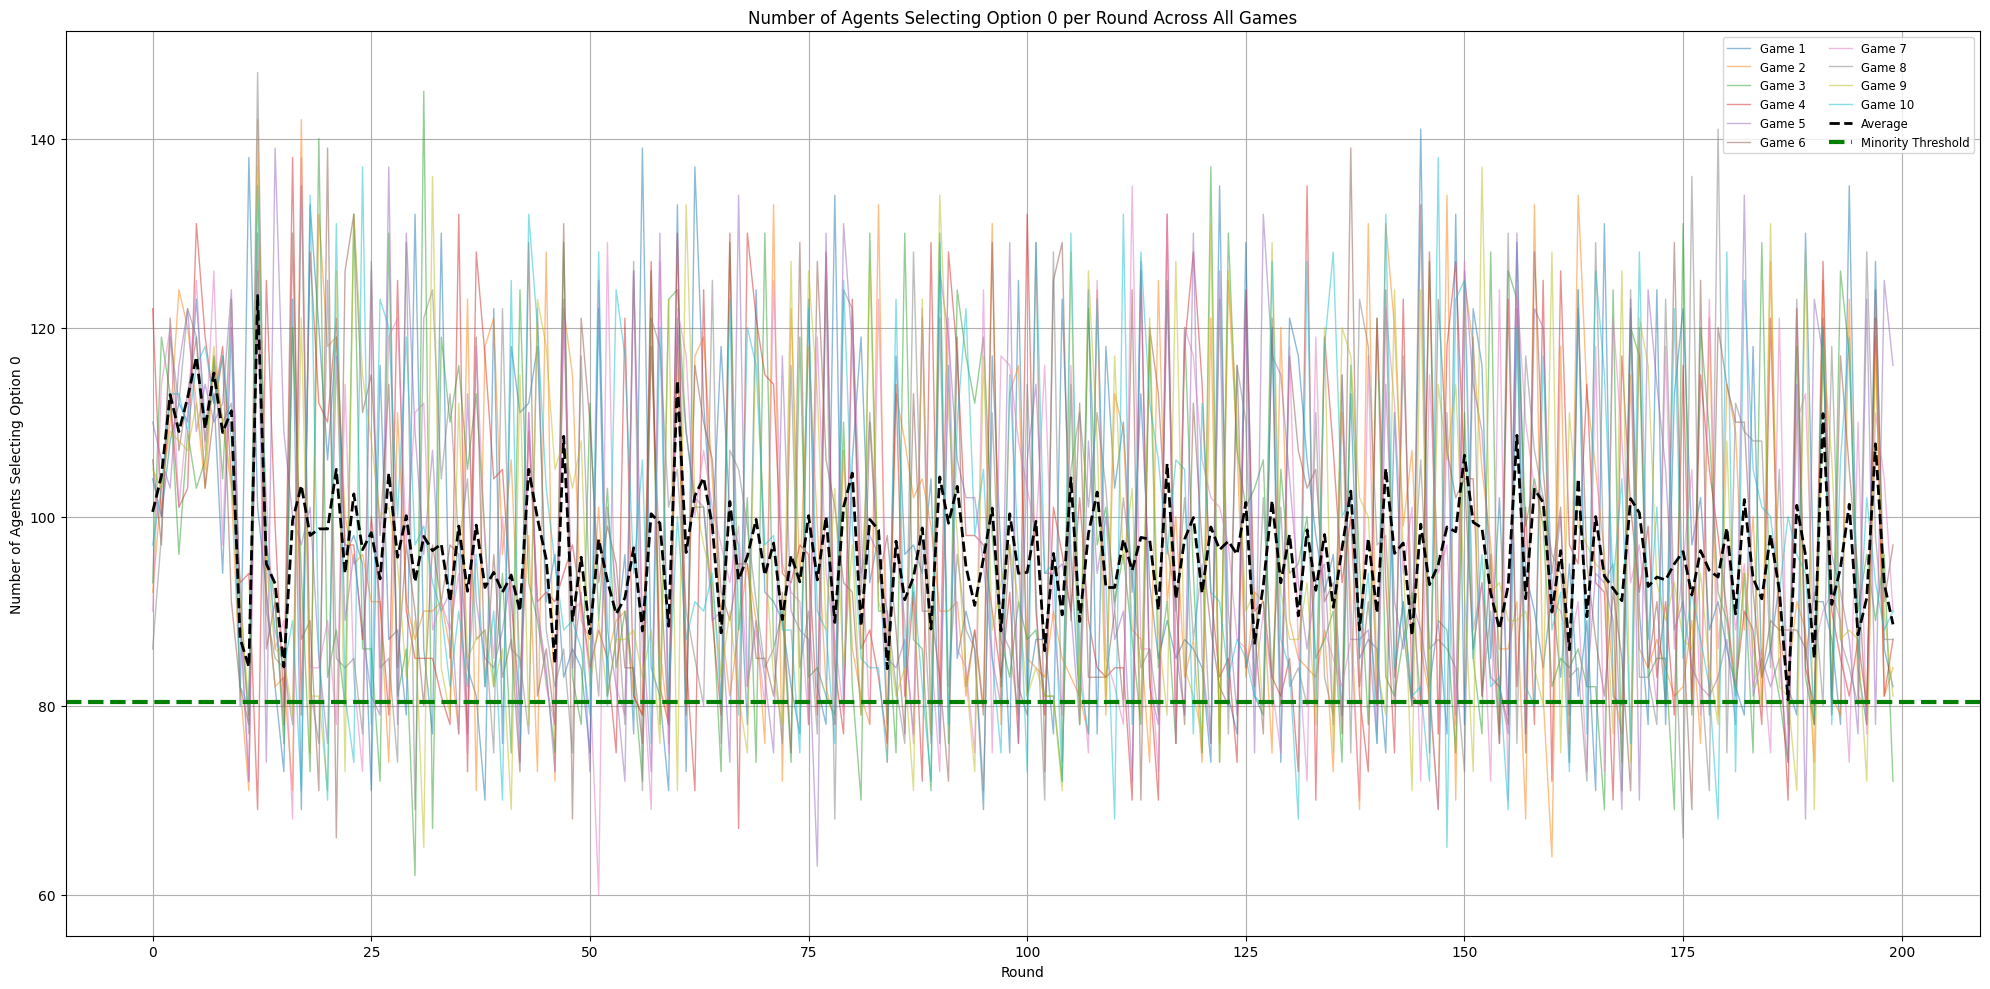

In [15]:
simulation.plot_agents_in_minority()

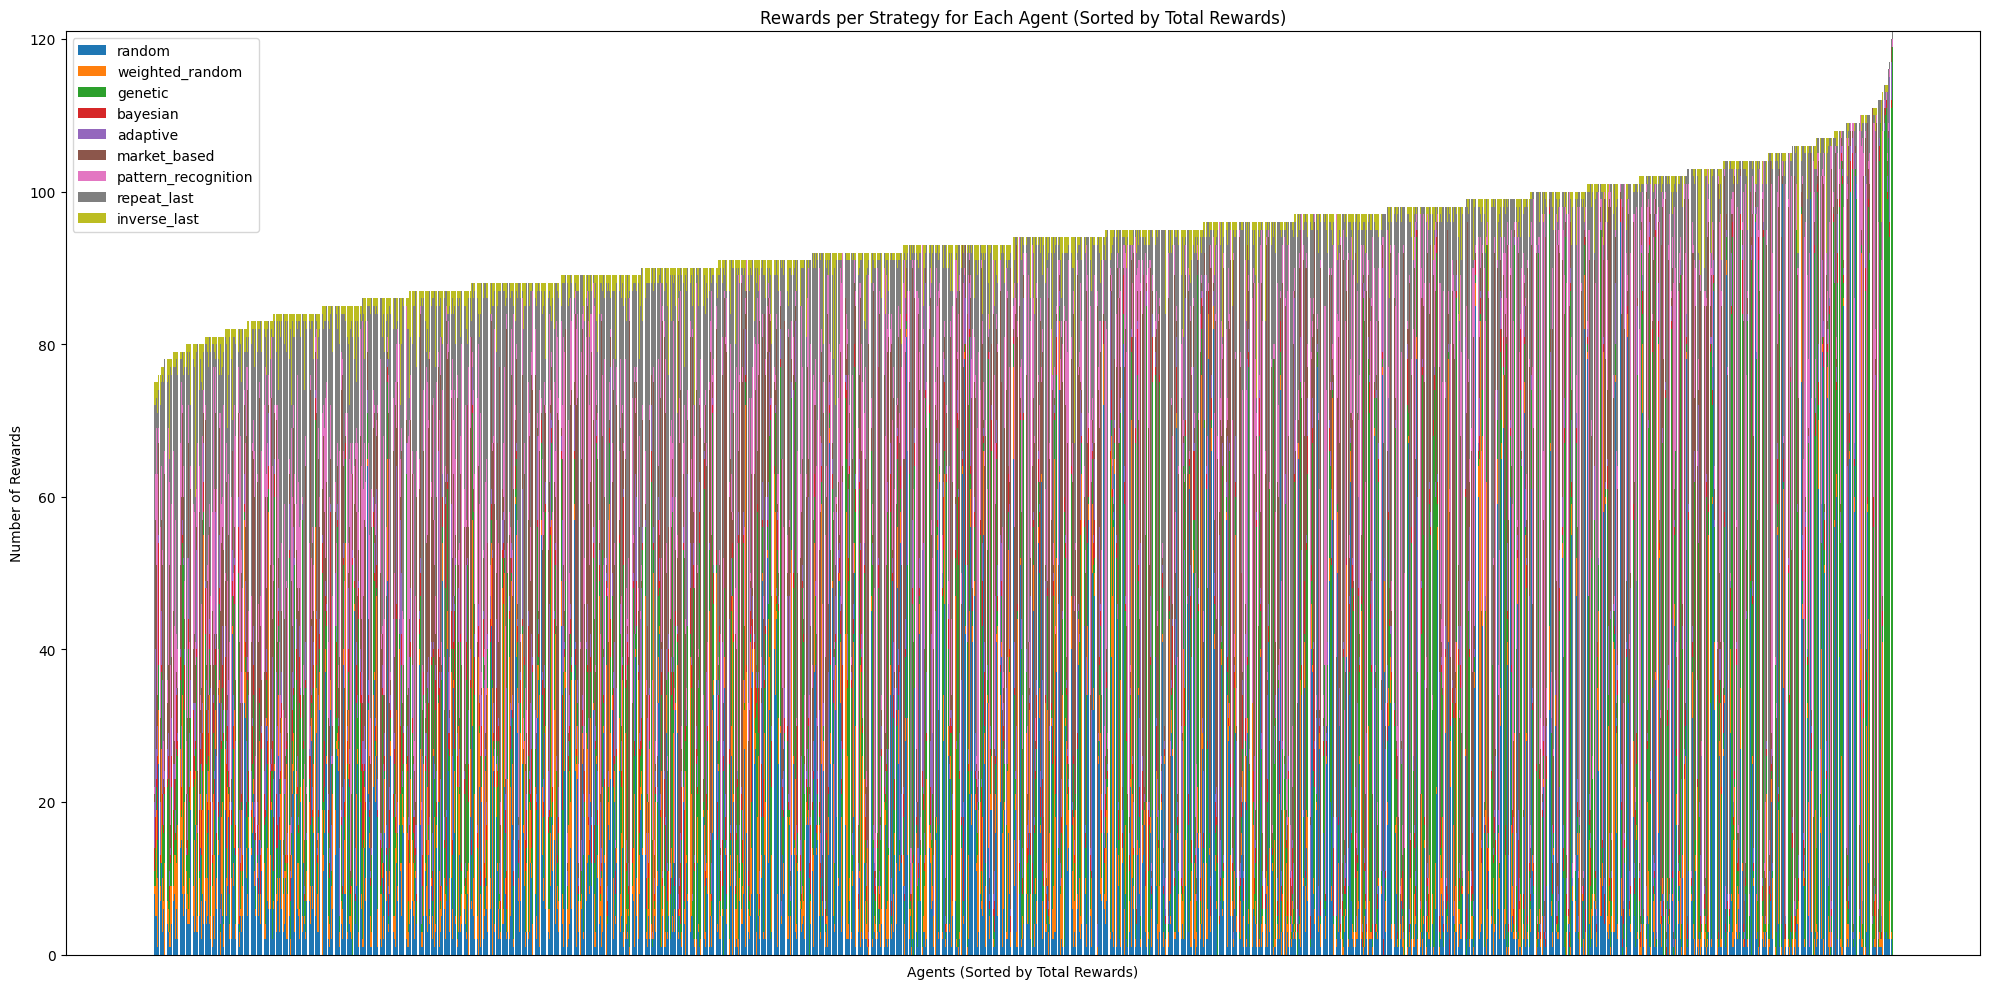

In [16]:
simulation.plot_agent_scores_by_strategy()

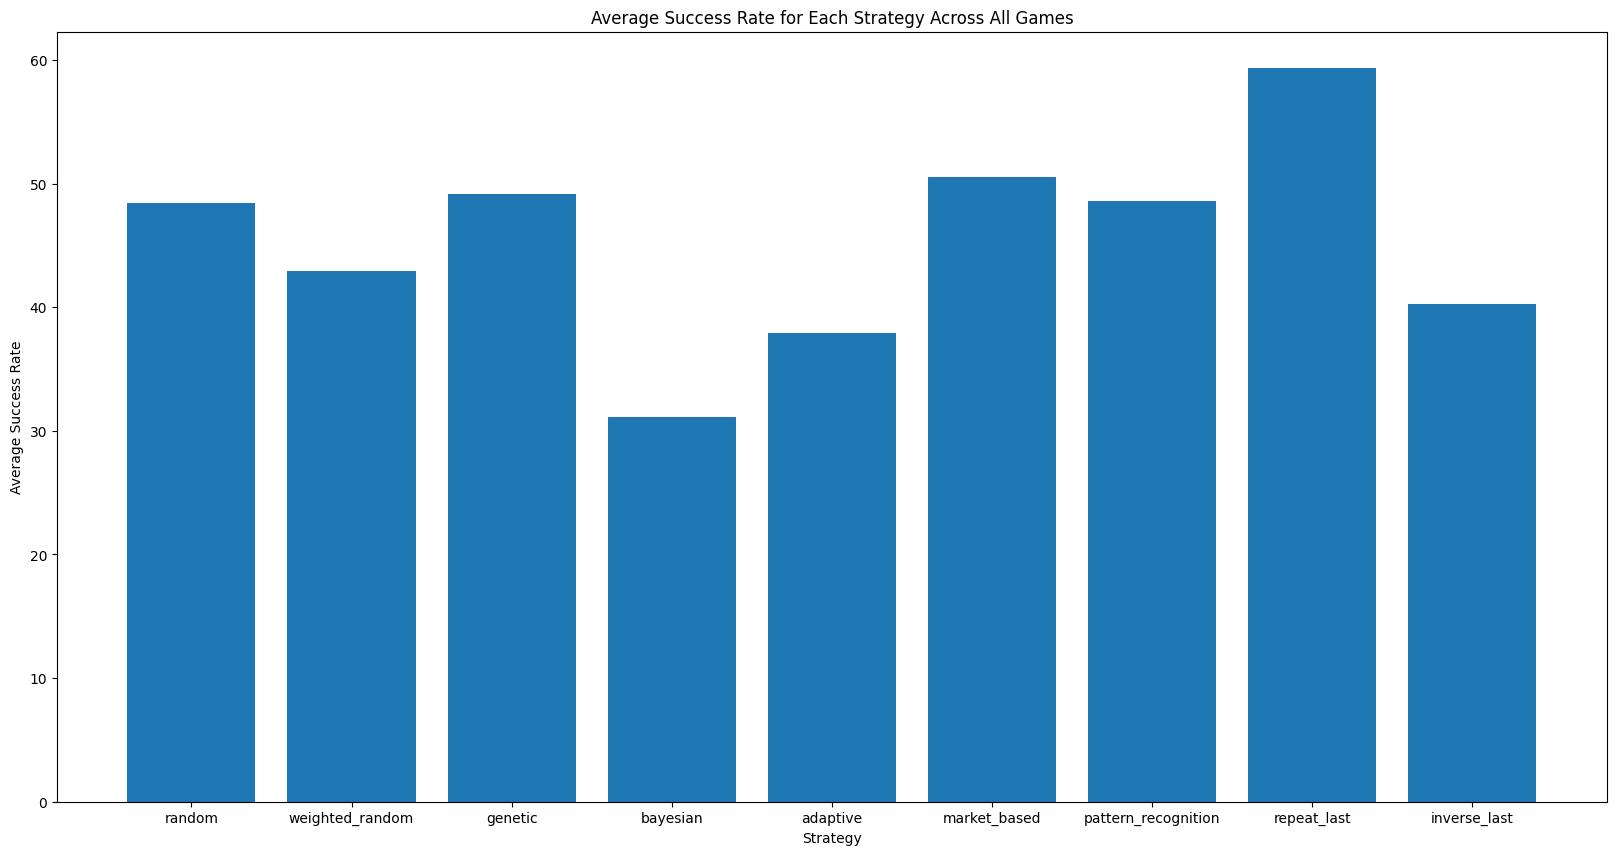

In [17]:
simulation.plot_average_strategy_success()

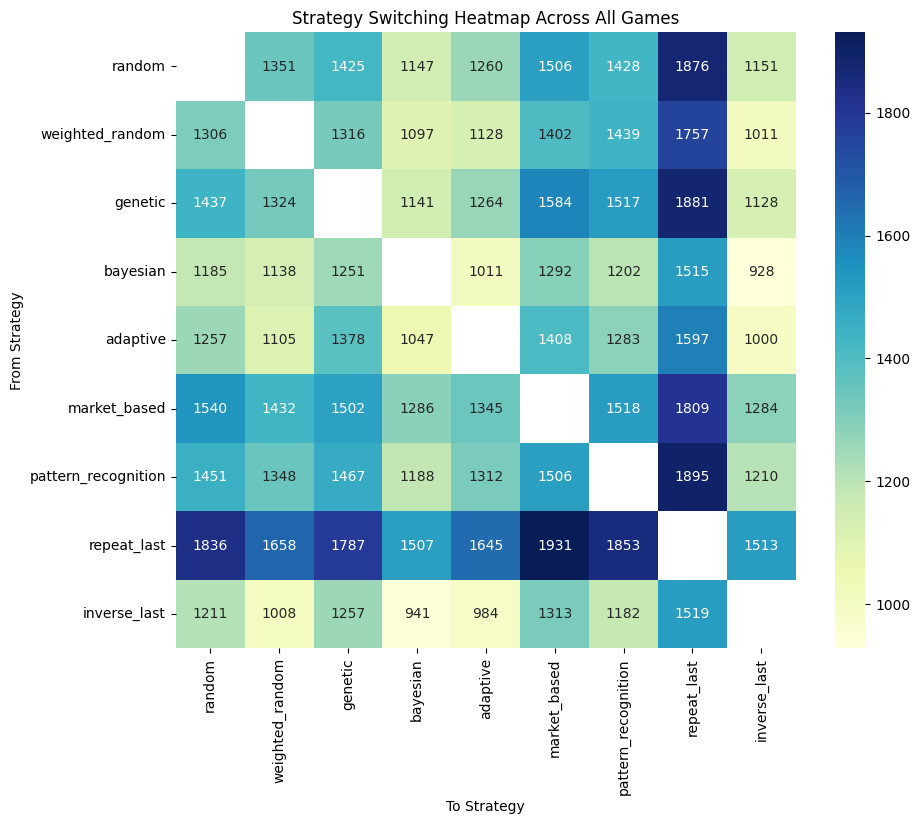

In [18]:
simulation.plot_switching_heatmap()

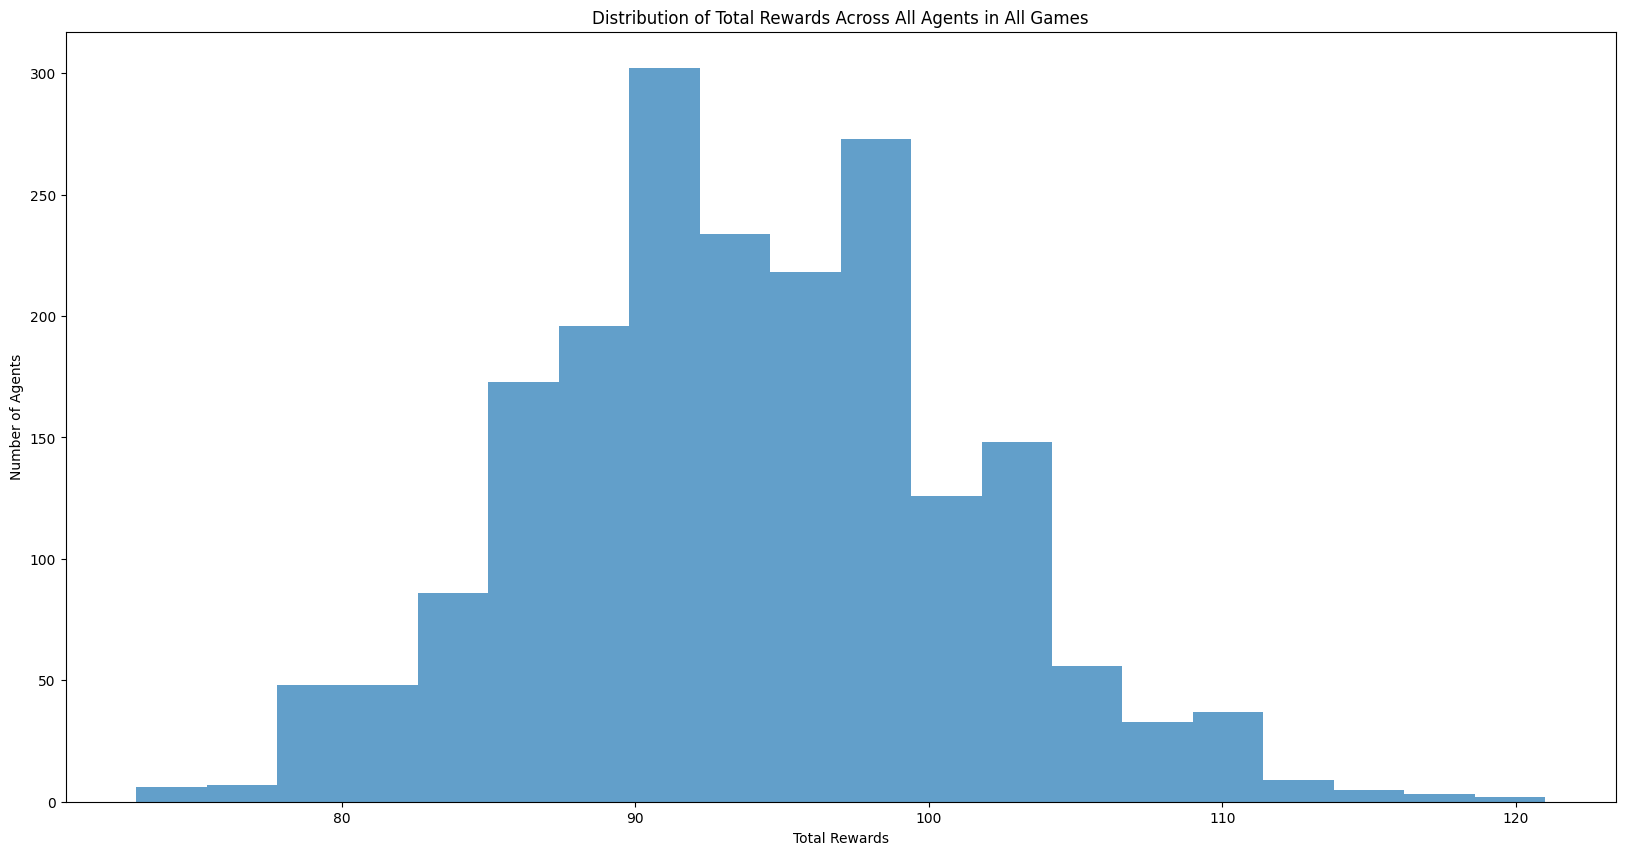

In [19]:
simulation.plot_combined_rewards_distribution()

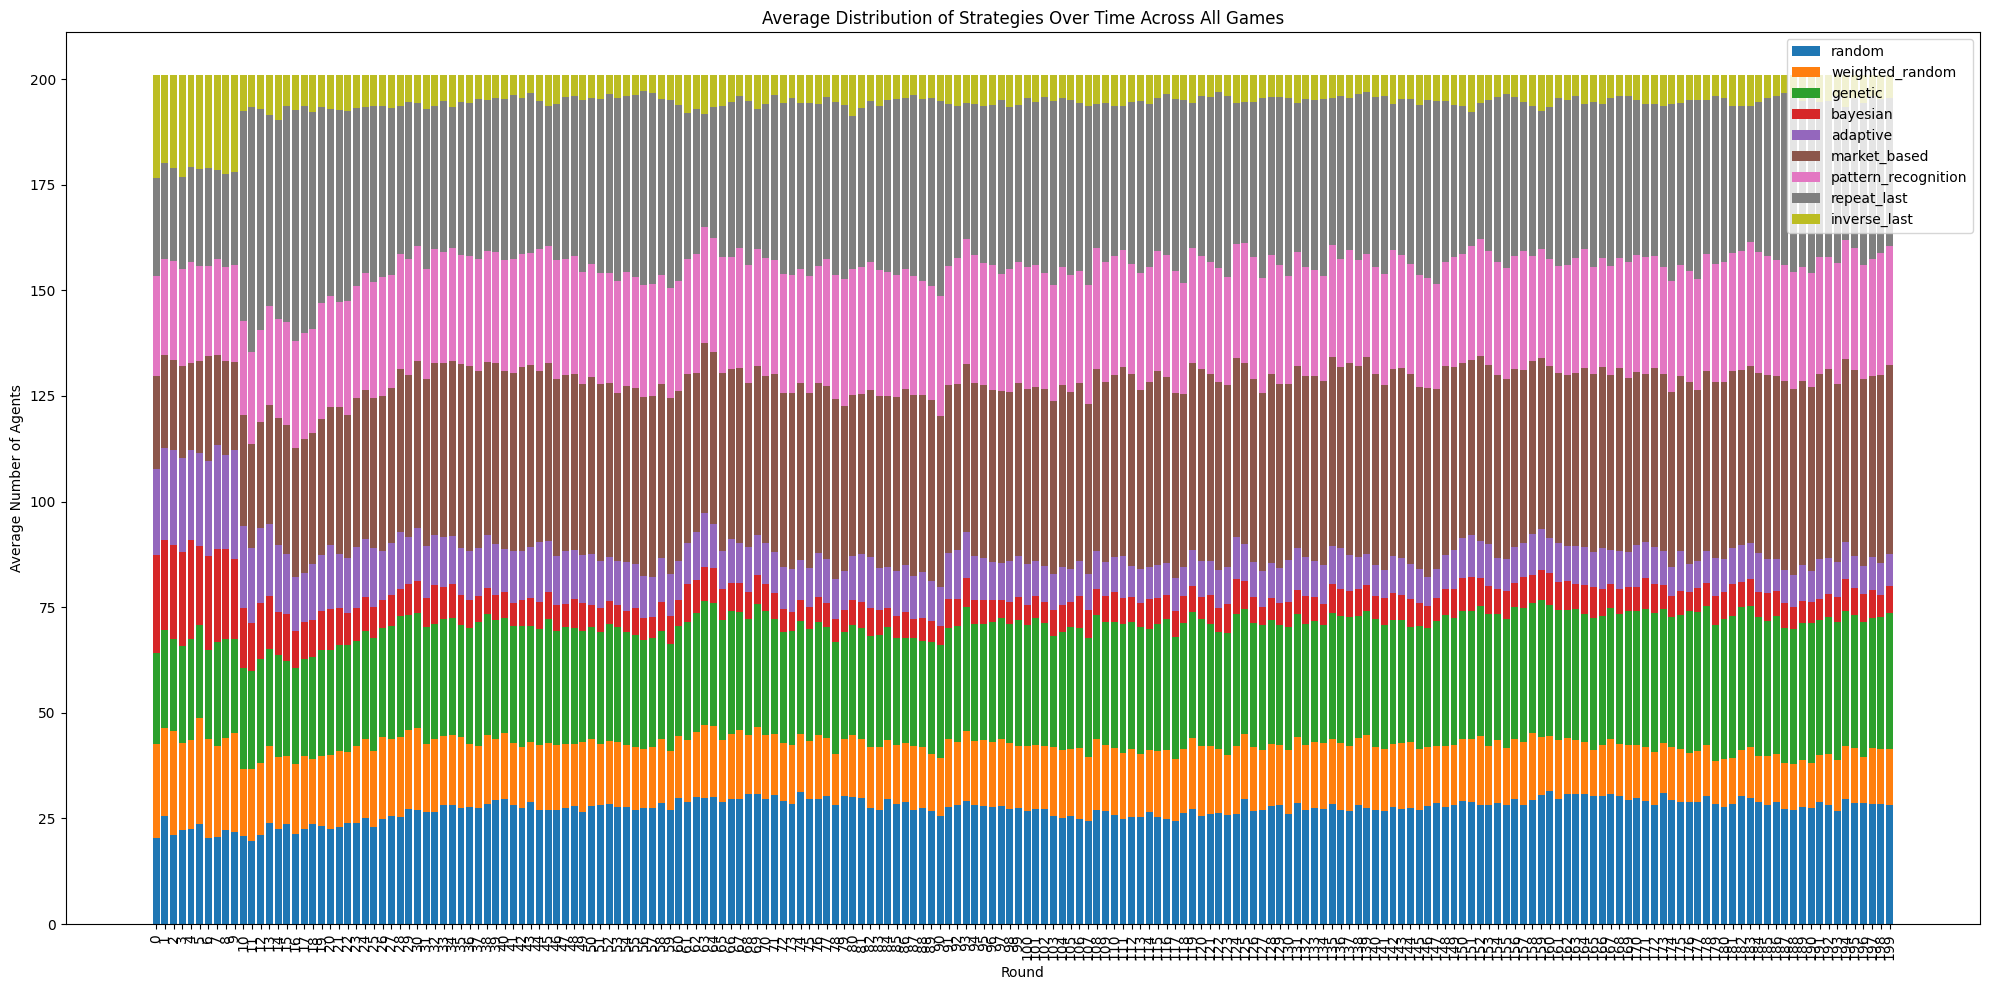

In [20]:
simulation.plot_combined_strategy_distribution()